In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
from enum import Enum, auto
import os

import numpy as np
from numpy import mean
from numpy import std

from scipy import signal
from scipy.fft import fft, fftfreq, rfft, rfftfreq

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
import joblib

from data_processing.config import BOOT_LABEL_FILE, POLE_LABEL_FILE, IMU_DATA_DIR, BOOT_MODEL_FILE, POLE_MODEL_FILE
from data_processing.labels_util import (
    get_labels_data, LabelCol, get_workouts_row_bounds, get_workouts_epoch_bounds, get_workouts_sensor
)
from data_processing.imu_util import (
    get_sensor_file, ImuCol, load_imu_data, Sensor, fix_epoch, resample_uniformly, time_to_row_range, 
    preprocess_imu_data, get_data_chunk, normalize_with_bounds, data_to_features
)
from data_processing.data_util import find_nearest, find_nearest_index, shift
from data_processing.enums import Activity
from predict.predict import load_model, group_points, merge_groups, classify_imu_datapoints
from visualization.visualize import multiplot

# import data types
from pandas import DataFrame
from numpy import ndarray
from typing import List, Tuple, Optional

# Step Bounds Detection
Given IMU data for a specific workout, detect each ski step and their bounds. Use the GBM models for pole and boot.

## Setup
Load an IMU data file for testing. This step bound detection should be computed 

In [2]:
# CHOOSE ONE
activity = Activity.Pole

# Test data. Found these by graphing the sensor file
if activity == Activity.Pole:
    imu_file = IMU_DATA_DIR / '7L_2020-10-17T09.39.55.613_EF6A3F7ADFF6_Accelerometer.csv'
    # NOTE: these bounds are innacurate. Just eyeballed. In practice, they're also manually inputted by the user
    workout_range = (96489, 108515)
else:
    imu_file = IMU_DATA_DIR / '8L_2020-10-17T09.41.54.354_E1051277C793_Accelerometer.csv'
    workout_range = (38403, 52903)
    
    # Below may be a sensor worn upside down? Or maybe a different ski technique?
    #imu_file = IMU_DATA_DIR / '7L_2020-10-17T09.39.55.613_EF6A3F7ADFF6_Accelerometer.csv'
    #workout_range = (45720, 59585)
    
imu_data: ndarray = load_imu_data(imu_file)

# # Plot
# def plot_helper(plot_id, plot):
#     plot.plot(imu_data[:, ImuCol.XACCEL], label = "x-axis acceleration")
#     plot.legend()
# multiplot(1, plot_helper)

## Clean data
Clean data exactly like backend does when receiving an "upload" file request.

<IPython.core.display.Javascript object>


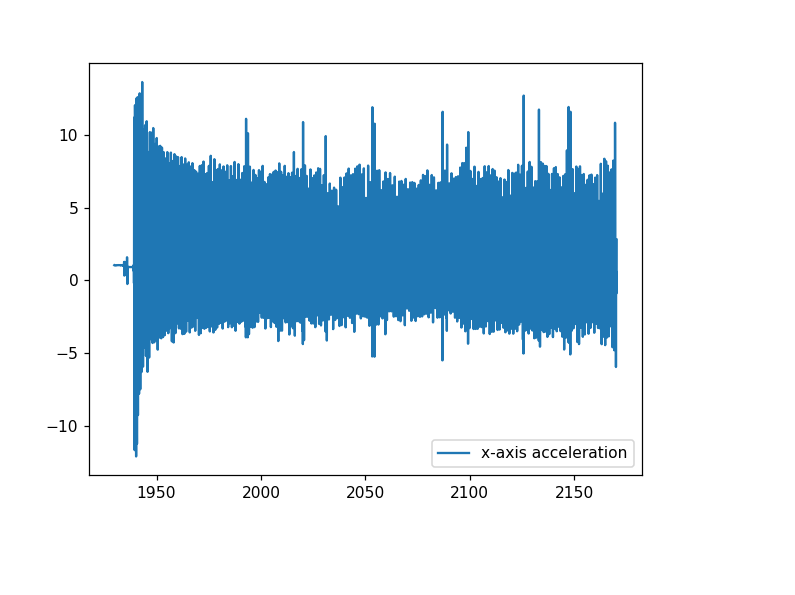

In [3]:
# Pre-process
imu_data = preprocess_imu_data(imu_data)

def plot_helper(plot_id, plot):
    plot.plot(imu_data[workout_range[0]:workout_range[1] + 1, ImuCol.TIME], 
              imu_data[workout_range[0]:workout_range[1] + 1, ImuCol.XACCEL], label = "x-axis acceleration")
    plot.legend()
multiplot(1, plot_helper)

## Classify data points using the Gradient Boosting Machine
Use the Gradient Boosting Machine to predict which data points are steps and which ones are non-steps.

In [4]:
classification = classify_imu_datapoints(imu_data, workout_range[0], workout_range[1], activity)

print('Percent of steps data points', np.count_nonzero(classification == 1) / len(classification))

# # Plot results
# def plot_helper(plot_id, plot):
#     plot.plot(imu_data[workout_range[0]:workout_range[1]+1, ImuCol.TIME], 
#               imu_data[workout_range[0]:workout_range[1]+1, ImuCol.XACCEL], label = "x-axis acceleration")
    
#     # plot steps
#     for i in range(len(classification)):
#         if classification[i] == 0:
#             continue
#         plot.axvline(x=imu_data[workout_range[0] + i, ImuCol.TIME], linestyle='dashed', color='green')
        
#     plot.legend()
    
# multiplot(1, plot_helper)

Percent of steps data points 0.6101272137690197


## Group points into steps
Group consecutive points that span ```x``` seconds into one step.

<IPython.core.display.Javascript object>


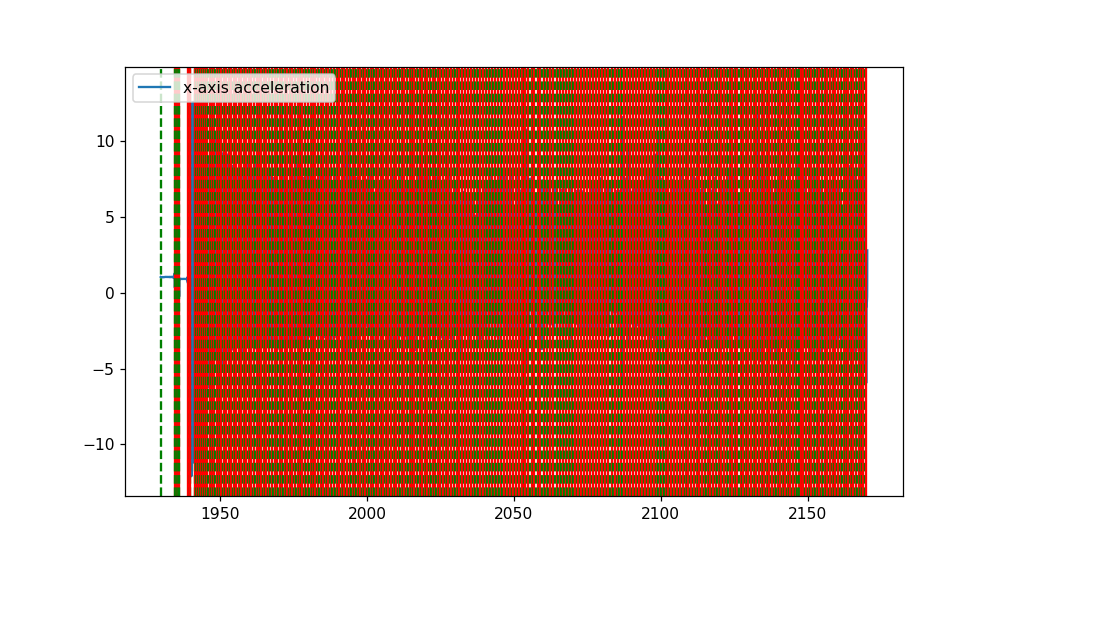

In [5]:
GROUPING_SIZE = 8 # this should depend on the sampling interval. This value should equal 5*0.02 = 0.1 seconds

            
all_steps: List[Tuple[int, int]] = group_points(classification)
            
# Plot steps
def plot_helper(plot_id, plot):
    plot.plot(imu_data[workout_range[0]:workout_range[1]+1, ImuCol.TIME], 
              imu_data[workout_range[0]:workout_range[1]+1, ImuCol.XACCEL], label = "x-axis acceleration")
    
#     for i in range(len(classification)):
#         if classification[i] == 0:
#             continue
#         plot.axvline(x=imu_data[i, ImuCol.TIME], linestyle='dotted', color='yellow')
    
    for start, end in all_steps:
        plot.axvline(x=imu_data[workout_range[0] + start, ImuCol.TIME], linestyle='dashed', color='green')
        plot.axvline(x=imu_data[workout_range[0] + end, ImuCol.TIME], linestyle='solid', color='red')
        
    plot.legend()
    
multiplot(1, plot_helper)

Merge steps that are within ```x``` seconds of each other

<IPython.core.display.Javascript object>


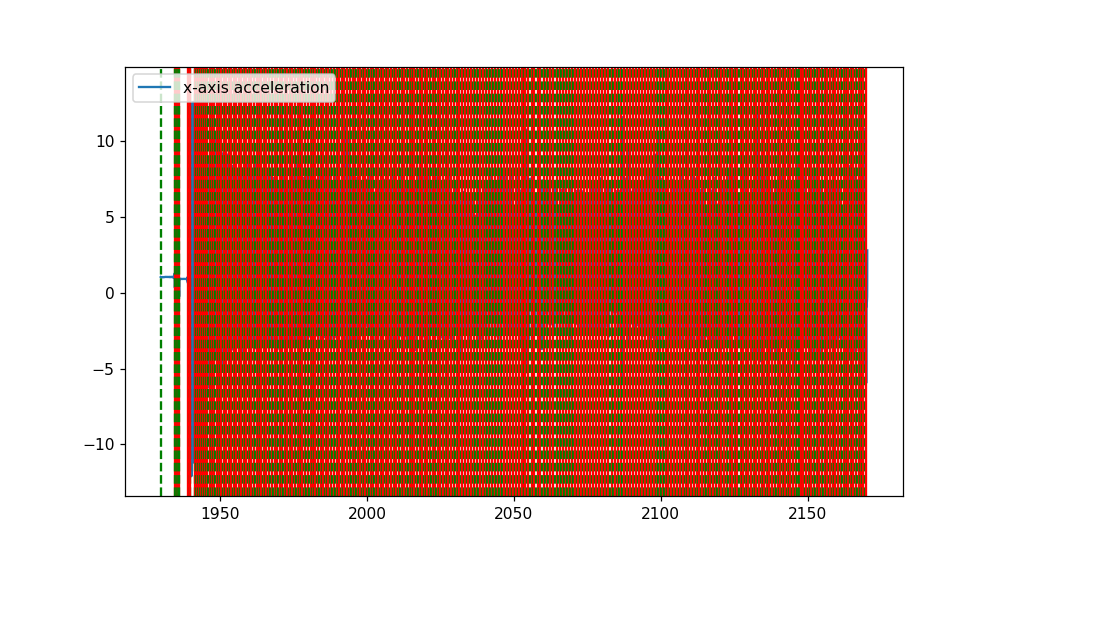

In [6]:
STEP_MIN = 10

final_steps = merge_groups(all_steps)

# Plot steps
def plot_helper(plot_id, plot):
    plot.plot(imu_data[workout_range[0]:workout_range[1]+1, ImuCol.TIME], 
              imu_data[workout_range[0]:workout_range[1]+1, ImuCol.XACCEL], label = "x-axis acceleration")
            
#     for i in range(len(classification)):
#         if classification[i] == 0:
#             continue
#         plot.axvline(x=imu_data[i, ImuCol.TIME], linestyle='dotted', color='yellow')
    
    for start, end in all_steps:
        plot.axvline(x=imu_data[workout_range[0] + start, ImuCol.TIME], linestyle='dashed', color='green')
        plot.axvline(x=imu_data[workout_range[0] + end, ImuCol.TIME], linestyle='solid', color='red')
        
    plot.legend()
    
multiplot(1, plot_helper)